In [1]:
from pickle import load, dump
from keras.utils import plot_model
from keras.models import Model
from keras.layers import *
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
import random
from numpy import array
from os import listdir
from pickle import dump,load

C:\Users\Hema\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load photo features
def load_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

In [3]:
#load training dataset (6K)
filename = 'train_plant.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
#load training dataset (6K)
''filename = 'test_plant.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

#load c2d features
train_features = load_features('resnet152_features.pkl', train)
print('C2D: train=%d' % len(train_features))

#load c2d features
test_features=load_features('resnet152_features.pkl', test)
print('C2D: train=%d' % len(test_features))

#load c2d features
train_labels = load_features('disease_label.pkl', train)
print('C2D: train=%d' % len(train_labels))

#load c2d features
test_labels=load_features('disease_label.pkl', test)
print('C2D: train=%d' % len(test_labels))


Xtrain=list()
Ytrain=list()
for i in train_features:
    Xtrain.append(train_features[i][0])
    Ytrain.append(train_labels[i])

Xtrain=np.array(Xtrain)
print(Xtrain.shape)
Ytrain=np.array(Ytrain)
print(Ytrain.shape)

Xtest=list()
Ytest=list()
for i in test_features:
    Xtest.append(test_features[i][0])
    Ytest.append(test_labels[i])

Xtest=np.array(Xtest)
print(Xtest.shape)
Ytest=np.array(Ytest)
print(Ytest.shape)


Dataset: 9555
Dataset: 2712
C2D: train=9555
C2D: train=2712
C2D: train=9555
C2D: train=2712
(9555, 2048)
(9555, 16)
(2712, 2048)
(2712, 16)


In [7]:
# define baseline model
def baseline_model():
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    #fe1 = Dropout(0.2)(inputs1)
    fe1 = Dense(512, activation='relu')(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)

    outputs = Dense(16, activation='softmax')(fe2)
    # tie it together [image, seq] [word]
    model = Model(inputs=inputs1, outputs=outputs)
        # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize model
    model.summary()
    #plot_model(model, to_file='model_classify_domain.png', show_shapes=True)
    return model
model=baseline_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
Total params: 1,116,816
Trainable params: 1,116,816
Non-trainable params: 0
_________________________________________________________________


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [7]:

epochs = 20
batch_size=100
steps=len(train_features)
for i in range(epochs):
    print(i)
    # create the data generator
    #generator = data_generator(train_features,train_labels,batch_size)
    # fit for one epoch
    #model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # model.evaluate_generator(generator=valid_generator)
    history = model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=1)
    # save model
    model.save('D:\Aravind\Matlab tutorial\SIH\classification\complete_disease\disease_model_new\model_' + str(i) + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
Total params: 1,116,816
Trainable params: 1,116,816
Non-trainable params: 0
_________________________________________________________________
0
Epoch 1/1
9555/9555 [==============================] - 6s 606us/step - loss: 0.4289 - acc: 0.8588
1
Epoch 1/1
9555/9555 [==============================] - 5s 498us/step - loss: 0.1130 - acc: 0.9598
2
Epoch 1/1
9555/9555 [==============================] - 5s 526u

# Evaluation

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from keras.models import load_model
import matplotlib.pyplot as plt

In [15]:
model = load_model('D:\Aravind\Matlab tutorial\SIH\classification\complete_disease\disease_model\model_15.h5')

#accuracy for test
predictions=list()
pr_test=dict()
y_label=list()
count=0
for i in test_features:
    #print(i)
    x_n=np.array(test_features[i])
    #score = model.evaluate(x, y, batch_size=batch_size)
    preds=model.predict([x_n])
    labels = np.argmax(preds, axis=-1) 
    predictions.append(labels[0])
    y_label.append(test_labels[i])
    pr_test[count]=i
    count+=1
    
predictions_test=np.array(predictions)
ytest=np.array(y_label)
pred_label = preprocessing.LabelBinarizer()
test_predicted_label=pred_label.fit_transform(predictions_test)

Ytest=Ytest.astype(int)

#accuracy for train:
predictions=list()
pr_train=dict()
y_label=list()
count=0
for i in train_features:
    #print(i)
    x_n=np.array(train_features[i])
    #score = model.evaluate(x, y, batch_size=batch_size)
    preds=model.predict([x_n])
    labels = np.argmax(preds, axis=-1) 
    predictions.append(labels[0])
    y_label.append(train_labels[i])
    pr_train[count]=i
    count+=1
    
predictions_train=np.array(predictions)
ytrain=np.array(y_label)
pred_label = preprocessing.LabelBinarizer()
train_predicted_label=pred_label.fit_transform(predictions_train)

Ytrain=Ytrain.astype(int)


In [16]:
cm = confusion_matrix(Ytest.argmax(axis=1), test_predicted_label.argmax(axis=1))
print(cm)

print("Accuracy = ",accuracy_score(Ytest.argmax(axis=1), test_predicted_label.argmax(axis=1)))
print("Accuracy = ",accuracy_score(Ytrain.argmax(axis=1), train_predicted_label.argmax(axis=1)))

[[121   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 122   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0  54   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  84   0  17   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 205   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  11   1 184   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 213   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3 225   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 214   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 198   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0  28   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1 197   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 204   2   2   2]
 [  1   0   0   0   0   0   0   0   0   0   0   3   1 188   6   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   2 205 

In [17]:
train_acc_x=np.zeros((20,1))
train_acc_y=np.zeros((20,1))
test_acc_x=np.zeros((20,1))
test_acc_y=np.zeros((20,1))
c=0
for j in range(0,20,1):
    print(j)
    model = load_model('D:\Aravind\Matlab tutorial\SIH\classification\complete_disease\disease_model\model_' + str(j) + '.h5')
    predictions=list()
    count=0
    for i in train_features:
        #print(i)
        x_n=np.array(train_features[i])
        #score = model.evaluate(x, y, batch_size=batch_size)
        preds=model.predict([x_n])
        labels = np.argmax(preds, axis=-1) 
        predictions.append(labels[0])
    predictions=np.array(predictions)
    pred_label = preprocessing.LabelBinarizer()
    predicted_label=pred_label.fit_transform(predictions)
    Ytrain=Ytrain.astype(int)
    train_acc_x[c]=c
    train_acc_y[c]=accuracy_score(Ytrain.argmax(axis=1), predicted_label.argmax(axis=1))
    predictions=list()
    count=0
    for i in test_features:
        #print(i)
        x_n=np.array(test_features[i])
        #score = model.evaluate(x, y, batch_size=batch_size)
        preds=model.predict([x_n])
        labels = np.argmax(preds, axis=-1) 
        predictions.append(labels[0])
    predictions=np.array(predictions)
    pred_label = preprocessing.LabelBinarizer()
    predicted_label=pred_label.fit_transform(predictions)
    Ytest=Ytest.astype(int)
    test_acc_x[c]=c
    test_acc_y[c]=accuracy_score(Ytest.argmax(axis=1), predicted_label.argmax(axis=1))
    c+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


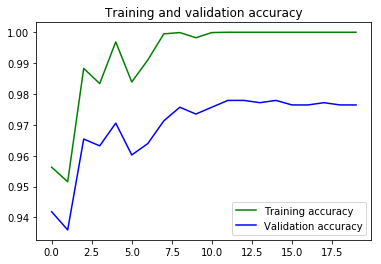

In [13]:
plt.figure()

plt.plot(train_acc_x, train_acc_y, 'g', label='Training accuracy')
plt.plot(test_acc_x, test_acc_y, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [18]:
print(train_acc_y)
print(test_acc_y)

[[0.95625327]
 [0.95154369]
 [0.98827839]
 [0.9833595 ]
 [0.99686028]
 [0.98388278]
 [0.99099948]
 [0.99947671]
 [0.99989534]
 [0.99822083]
 [0.99989534]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
[[0.94284661]
 [0.93362832]
 [0.96349558]
 [0.96017699]
 [0.97123894]
 [0.9520649 ]
 [0.95980826]
 [0.97566372]
 [0.97566372]
 [0.9730826 ]
 [0.97566372]
 [0.97529499]
 [0.97566372]
 [0.97603245]
 [0.97492625]
 [0.97566372]
 [0.97676991]
 [0.97787611]
 [0.97787611]
 [0.97676991]]
